<a href="https://colab.research.google.com/github/kareem1925/Ismailia-school-of-AI/blob/master/quantum_gradients/universal_qubit_classifier_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install qiskit -q --upgrade

In [0]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
from qiskit.quantum_info.analysis import average_data
from qiskit.quantum_info import state_fidelity
from sklearn.metrics import accuracy_score,log_loss
import numpy as np

np.random.seed(0)

In [0]:
y = np.array(([1,0]))
y1 = np.array(([0,1]))
State_labels = [y,y1]

In [0]:
def circuit(params,X,y):
    
    n_qubits = len(params)
    layers = len(params[0][0])
    qc = QuantumCircuit(n_qubits)
    
    
    for i in range(len(params)):
        
        for id,j in enumerate(params[i]):
            qc.u3(X[0],X[1],0,i)
            
            qc.u3(j[0],j[1],j[2],i)
            if n_qubits > 1 and (id < layers-1):
                qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    counts = result_sim.get_statevector(qc)
    vals = state_fidelity(counts,State_labels[0])
    vals1 = state_fidelity(counts,State_labels[1])
    #print(average_data(counts,vals))
    return [vals,vals1]

In [0]:
def cost(params,X,y):
    
    value = []
    
    for i in range(len(X)):
        value.append(circuit(params,X[i],y[i]))
    res = log_loss(y,value,labels=y_train)
   # print(res)
    return res
        

In [0]:
def gradient(params,x,y):
    
    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                
        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,x,y)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
                
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
    
                F2 = cost(params,x,y)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g
    
def optimize(params,X,y,lr): 
    g = gradient(params,X,y)
    
    new_weights = params - (lr*g)
    
    return new_weights

In [0]:
def _circle(samples):
    centers = np.array([[0, 0]])
    radii = np.array([np.sqrt(1.8/np.pi)])
    data=[]
    dim = 2
    labels=[]
    np.random.seed(1000)
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for c, r in zip(centers, radii):  
            if np.linalg.norm(x - c) < r:
                y = 1 

        data.append(x)
        labels.append(y)
            
    return np.array(data), np.array(labels)

(810, 2) (90, 2)


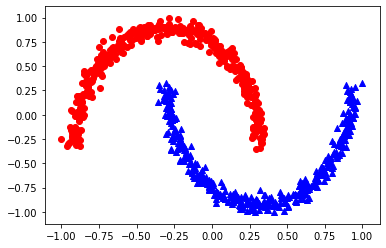

In [10]:
from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt
#X,l = _circle(1000)
X,l = make_moons(n_samples=900,random_state=0,noise=0.04)
x_train,x_test,y_train,y_test = train_test_split(X,l,test_size=0.1,random_state=0,stratify=l)
print(x_train.shape,x_test.shape)
scale = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scale.transform(x_train)
x_test = scale.transform(x_test)

plt.scatter(x_train[:,0][y_train==0], x_train[:,1][y_train==0], marker='o', color='red', label='train 0')
plt.scatter(x_train[:,0][y_train==1], x_train[:,1][y_train==1], marker='^', color='blue', label='train 1')

In [0]:
def predict(params,X):
    
    n_qubits = len(params)
    layers = len(params[0][0])
    qc = QuantumCircuit(n_qubits)
    
    
    for i in range(len(params)):
        
        for id,j in enumerate(params[i]):
            qc.u3(X[0],X[1],0,i)
            
            qc.u3(j[0],j[1],j[2],i)
            if n_qubits > 1 and (id < layers-1):
                qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    counts = result_sim.get_statevector(qc)
    
        
    vals = state_fidelity(counts,State_labels[0])
    
    vals1 = state_fidelity(counts,State_labels[1])
    #print(average_data(counts,vals))
    if vals > vals1:
        return abs(1-vals)
    else:
        
        return vals1
    

In [12]:
from tqdm import tqdm
np.random.seed(100)
params = np.random.rand(1,6,3)
weights = params
score = np.inf
lr = 0.2
test_loss = []
for i in tqdm(range(400)):

    index = np.random.randint(0,len(x_train),20)
    x_batch,y_batch = x_train[index],y_train[index]
    #if i+1 == 500 or i+1 == 800:
     #   lr = lr - 0.05
    weights = optimize(weights,x_batch,y_batch,lr=lr)
    
    res = cost(weights,x_test,y_test)
    test_loss.append(res)
    #acc_test = accuracy_score(y_test,np.round(np.array(res)))
        
    if res < score:
        score = res
        var = weights
    print(
        "Epoch: {:2d} | testing loss: {:4f}".format(i+1,res))

  0%|          | 1/400 [00:06<42:38,  6.41s/it]

Epoch:  1 | testing loss: 0.702237


  0%|          | 2/400 [00:12<42:20,  6.38s/it]

Epoch:  2 | testing loss: 0.600879


  1%|          | 3/400 [00:19<42:06,  6.36s/it]

Epoch:  3 | testing loss: 0.590562


  1%|          | 4/400 [00:25<41:56,  6.35s/it]

Epoch:  4 | testing loss: 0.558180


  1%|▏         | 5/400 [00:31<41:49,  6.35s/it]

Epoch:  5 | testing loss: 0.496094


  2%|▏         | 6/400 [00:38<41:44,  6.36s/it]

Epoch:  6 | testing loss: 0.504841


  2%|▏         | 7/400 [00:44<41:28,  6.33s/it]

Epoch:  7 | testing loss: 0.452597


  2%|▏         | 8/400 [00:50<41:43,  6.39s/it]

Epoch:  8 | testing loss: 0.388533


  2%|▏         | 9/400 [00:57<41:57,  6.44s/it]

Epoch:  9 | testing loss: 0.359905


  2%|▎         | 10/400 [01:03<41:42,  6.42s/it]

Epoch: 10 | testing loss: 0.331875


  3%|▎         | 11/400 [01:10<41:32,  6.41s/it]

Epoch: 11 | testing loss: 0.297817


  3%|▎         | 12/400 [01:16<41:24,  6.40s/it]

Epoch: 12 | testing loss: 0.290814


  3%|▎         | 13/400 [01:22<41:13,  6.39s/it]

Epoch: 13 | testing loss: 0.274050


  4%|▎         | 14/400 [01:29<41:00,  6.38s/it]

Epoch: 14 | testing loss: 0.270941


  4%|▍         | 15/400 [01:35<40:49,  6.36s/it]

Epoch: 15 | testing loss: 0.268381


  4%|▍         | 16/400 [01:41<40:39,  6.35s/it]

Epoch: 16 | testing loss: 0.263452


  4%|▍         | 17/400 [01:48<40:29,  6.34s/it]

Epoch: 17 | testing loss: 0.253752


  4%|▍         | 18/400 [01:54<40:27,  6.35s/it]

Epoch: 18 | testing loss: 0.240624


  5%|▍         | 19/400 [02:00<40:17,  6.34s/it]

Epoch: 19 | testing loss: 0.238736


  5%|▌         | 20/400 [02:07<40:09,  6.34s/it]

Epoch: 20 | testing loss: 0.259952


  5%|▌         | 21/400 [02:13<39:58,  6.33s/it]

Epoch: 21 | testing loss: 0.244111


  6%|▌         | 22/400 [02:19<39:50,  6.32s/it]

Epoch: 22 | testing loss: 0.236916


  6%|▌         | 23/400 [02:26<39:53,  6.35s/it]

Epoch: 23 | testing loss: 0.215186


  6%|▌         | 24/400 [02:32<40:06,  6.40s/it]

Epoch: 24 | testing loss: 0.212900


  6%|▋         | 25/400 [02:39<40:05,  6.41s/it]

Epoch: 25 | testing loss: 0.214780


  6%|▋         | 26/400 [02:45<39:44,  6.38s/it]

Epoch: 26 | testing loss: 0.235255


  7%|▋         | 27/400 [02:51<39:34,  6.37s/it]

Epoch: 27 | testing loss: 0.220845


  7%|▋         | 28/400 [02:58<39:23,  6.35s/it]

Epoch: 28 | testing loss: 0.204688


  7%|▋         | 29/400 [03:04<39:15,  6.35s/it]

Epoch: 29 | testing loss: 0.201362


  8%|▊         | 30/400 [03:10<39:08,  6.35s/it]

Epoch: 30 | testing loss: 0.204566


  8%|▊         | 31/400 [03:17<38:55,  6.33s/it]

Epoch: 31 | testing loss: 0.200383


  8%|▊         | 32/400 [03:23<38:53,  6.34s/it]

Epoch: 32 | testing loss: 0.199801


  8%|▊         | 33/400 [03:29<38:50,  6.35s/it]

Epoch: 33 | testing loss: 0.205394


  8%|▊         | 34/400 [03:36<38:48,  6.36s/it]

Epoch: 34 | testing loss: 0.197951


  9%|▉         | 35/400 [03:42<38:36,  6.35s/it]

Epoch: 35 | testing loss: 0.196062


  9%|▉         | 36/400 [03:49<38:30,  6.35s/it]

Epoch: 36 | testing loss: 0.192438


  9%|▉         | 37/400 [03:55<38:34,  6.38s/it]

Epoch: 37 | testing loss: 0.200256


 10%|▉         | 38/400 [04:01<38:29,  6.38s/it]

Epoch: 38 | testing loss: 0.191185


 10%|▉         | 39/400 [04:08<38:21,  6.38s/it]

Epoch: 39 | testing loss: 0.194472


 10%|█         | 40/400 [04:14<38:08,  6.36s/it]

Epoch: 40 | testing loss: 0.187909


 10%|█         | 41/400 [04:20<37:59,  6.35s/it]

Epoch: 41 | testing loss: 0.198587


 10%|█         | 42/400 [04:27<37:54,  6.35s/it]

Epoch: 42 | testing loss: 0.183535


 11%|█         | 43/400 [04:33<37:48,  6.35s/it]

Epoch: 43 | testing loss: 0.194741


 11%|█         | 44/400 [04:39<37:42,  6.36s/it]

Epoch: 44 | testing loss: 0.181897


 11%|█▏        | 45/400 [04:46<37:32,  6.35s/it]

Epoch: 45 | testing loss: 0.181562


 12%|█▏        | 46/400 [04:52<37:29,  6.35s/it]

Epoch: 46 | testing loss: 0.186388


 12%|█▏        | 47/400 [04:58<37:18,  6.34s/it]

Epoch: 47 | testing loss: 0.176157


 12%|█▏        | 48/400 [05:05<37:09,  6.33s/it]

Epoch: 48 | testing loss: 0.175836


 12%|█▏        | 49/400 [05:11<37:09,  6.35s/it]

Epoch: 49 | testing loss: 0.173715


 12%|█▎        | 50/400 [05:18<37:06,  6.36s/it]

Epoch: 50 | testing loss: 0.174573


 13%|█▎        | 51/400 [05:24<37:03,  6.37s/it]

Epoch: 51 | testing loss: 0.178913


 13%|█▎        | 52/400 [05:30<36:54,  6.36s/it]

Epoch: 52 | testing loss: 0.169386


 13%|█▎        | 53/400 [05:37<36:58,  6.39s/it]

Epoch: 53 | testing loss: 0.173824


 14%|█▎        | 54/400 [05:43<36:41,  6.36s/it]

Epoch: 54 | testing loss: 0.169044


 14%|█▍        | 55/400 [05:49<36:34,  6.36s/it]

Epoch: 55 | testing loss: 0.168130


 14%|█▍        | 56/400 [05:56<36:27,  6.36s/it]

Epoch: 56 | testing loss: 0.165400


 14%|█▍        | 57/400 [06:02<36:39,  6.41s/it]

Epoch: 57 | testing loss: 0.160496


 14%|█▍        | 58/400 [06:09<36:44,  6.45s/it]

Epoch: 58 | testing loss: 0.160374


 15%|█▍        | 59/400 [06:15<36:23,  6.40s/it]

Epoch: 59 | testing loss: 0.162828


 15%|█▌        | 60/400 [06:21<36:09,  6.38s/it]

Epoch: 60 | testing loss: 0.156964


 15%|█▌        | 61/400 [06:28<36:07,  6.39s/it]

Epoch: 61 | testing loss: 0.159912


 16%|█▌        | 62/400 [06:34<36:11,  6.42s/it]

Epoch: 62 | testing loss: 0.155105


 16%|█▌        | 63/400 [06:41<36:13,  6.45s/it]

Epoch: 63 | testing loss: 0.156187


 16%|█▌        | 64/400 [06:47<35:58,  6.42s/it]

Epoch: 64 | testing loss: 0.152951


 16%|█▋        | 65/400 [06:54<35:54,  6.43s/it]

Epoch: 65 | testing loss: 0.163310


 16%|█▋        | 66/400 [07:00<35:42,  6.42s/it]

Epoch: 66 | testing loss: 0.155545


 17%|█▋        | 67/400 [07:07<35:40,  6.43s/it]

Epoch: 67 | testing loss: 0.153741


 17%|█▋        | 68/400 [07:13<35:36,  6.44s/it]

Epoch: 68 | testing loss: 0.148080


 17%|█▋        | 69/400 [07:19<35:28,  6.43s/it]

Epoch: 69 | testing loss: 0.146229


 18%|█▊        | 70/400 [07:26<35:16,  6.41s/it]

Epoch: 70 | testing loss: 0.150969


 18%|█▊        | 71/400 [07:32<35:13,  6.42s/it]

Epoch: 71 | testing loss: 0.143374


 18%|█▊        | 72/400 [07:39<35:12,  6.44s/it]

Epoch: 72 | testing loss: 0.148880


 18%|█▊        | 73/400 [07:45<35:00,  6.42s/it]

Epoch: 73 | testing loss: 0.142970


 18%|█▊        | 74/400 [07:52<34:55,  6.43s/it]

Epoch: 74 | testing loss: 0.141753


 19%|█▉        | 75/400 [07:58<34:57,  6.45s/it]

Epoch: 75 | testing loss: 0.139384


 19%|█▉        | 76/400 [08:04<34:48,  6.45s/it]

Epoch: 76 | testing loss: 0.141065


 19%|█▉        | 77/400 [08:11<34:41,  6.44s/it]

Epoch: 77 | testing loss: 0.139562


 20%|█▉        | 78/400 [08:17<34:25,  6.41s/it]

Epoch: 78 | testing loss: 0.138763


 20%|█▉        | 79/400 [08:24<34:14,  6.40s/it]

Epoch: 79 | testing loss: 0.153951


 20%|██        | 80/400 [08:30<34:03,  6.39s/it]

Epoch: 80 | testing loss: 0.145739


 20%|██        | 81/400 [08:36<34:01,  6.40s/it]

Epoch: 81 | testing loss: 0.145778


 20%|██        | 82/400 [08:43<33:53,  6.39s/it]

Epoch: 82 | testing loss: 0.138807


 21%|██        | 83/400 [08:49<33:52,  6.41s/it]

Epoch: 83 | testing loss: 0.142380


 21%|██        | 84/400 [08:56<33:46,  6.41s/it]

Epoch: 84 | testing loss: 0.148911


 21%|██▏       | 85/400 [09:02<33:43,  6.42s/it]

Epoch: 85 | testing loss: 0.145417


 22%|██▏       | 86/400 [09:09<33:44,  6.45s/it]

Epoch: 86 | testing loss: 0.134395


 22%|██▏       | 87/400 [09:15<33:49,  6.48s/it]

Epoch: 87 | testing loss: 0.124895


 22%|██▏       | 88/400 [09:22<33:43,  6.49s/it]

Epoch: 88 | testing loss: 0.129223


 22%|██▏       | 89/400 [09:28<33:34,  6.48s/it]

Epoch: 89 | testing loss: 0.127569


 22%|██▎       | 90/400 [09:35<33:20,  6.45s/it]

Epoch: 90 | testing loss: 0.125656


 23%|██▎       | 91/400 [09:41<33:08,  6.43s/it]

Epoch: 91 | testing loss: 0.130117


 23%|██▎       | 92/400 [09:47<32:50,  6.40s/it]

Epoch: 92 | testing loss: 0.122564


 23%|██▎       | 93/400 [09:54<32:44,  6.40s/it]

Epoch: 93 | testing loss: 0.122065


 24%|██▎       | 94/400 [10:00<32:37,  6.40s/it]

Epoch: 94 | testing loss: 0.119589


 24%|██▍       | 95/400 [10:06<32:38,  6.42s/it]

Epoch: 95 | testing loss: 0.127886


 24%|██▍       | 96/400 [10:13<32:27,  6.40s/it]

Epoch: 96 | testing loss: 0.136428


 24%|██▍       | 97/400 [10:19<32:21,  6.41s/it]

Epoch: 97 | testing loss: 0.123097


 24%|██▍       | 98/400 [10:26<32:20,  6.42s/it]

Epoch: 98 | testing loss: 0.119405


 25%|██▍       | 99/400 [10:32<32:21,  6.45s/it]

Epoch: 99 | testing loss: 0.127755


 25%|██▌       | 100/400 [10:39<32:32,  6.51s/it]

Epoch: 100 | testing loss: 0.125177


 25%|██▌       | 101/400 [10:45<32:24,  6.50s/it]

Epoch: 101 | testing loss: 0.120791


 26%|██▌       | 102/400 [10:52<32:23,  6.52s/it]

Epoch: 102 | testing loss: 0.122051


 26%|██▌       | 103/400 [10:58<32:17,  6.52s/it]

Epoch: 103 | testing loss: 0.117249


 26%|██▌       | 104/400 [11:05<32:12,  6.53s/it]

Epoch: 104 | testing loss: 0.126316


 26%|██▋       | 105/400 [11:12<32:26,  6.60s/it]

Epoch: 105 | testing loss: 0.129570


 26%|██▋       | 106/400 [11:19<32:36,  6.65s/it]

Epoch: 106 | testing loss: 0.118520


 27%|██▋       | 107/400 [11:25<32:28,  6.65s/it]

Epoch: 107 | testing loss: 0.112619


 27%|██▋       | 108/400 [11:32<32:16,  6.63s/it]

Epoch: 108 | testing loss: 0.113154


 27%|██▋       | 109/400 [11:38<32:12,  6.64s/it]

Epoch: 109 | testing loss: 0.119081


 28%|██▊       | 110/400 [11:45<32:04,  6.64s/it]

Epoch: 110 | testing loss: 0.114741


 28%|██▊       | 111/400 [11:52<32:00,  6.65s/it]

Epoch: 111 | testing loss: 0.114893


 28%|██▊       | 112/400 [11:59<32:05,  6.69s/it]

Epoch: 112 | testing loss: 0.119144


 28%|██▊       | 113/400 [12:05<32:04,  6.70s/it]

Epoch: 113 | testing loss: 0.118361


 28%|██▊       | 114/400 [12:12<31:57,  6.71s/it]

Epoch: 114 | testing loss: 0.114491


 29%|██▉       | 115/400 [12:19<31:54,  6.72s/it]

Epoch: 115 | testing loss: 0.112723


 29%|██▉       | 116/400 [12:25<31:40,  6.69s/it]

Epoch: 116 | testing loss: 0.116684


 29%|██▉       | 117/400 [12:32<31:37,  6.70s/it]

Epoch: 117 | testing loss: 0.113301


 30%|██▉       | 118/400 [12:39<31:41,  6.74s/it]

Epoch: 118 | testing loss: 0.115626


 30%|██▉       | 119/400 [12:45<31:20,  6.69s/it]

Epoch: 119 | testing loss: 0.111399


 30%|███       | 120/400 [12:52<30:56,  6.63s/it]

Epoch: 120 | testing loss: 0.110005


 30%|███       | 121/400 [12:59<30:53,  6.64s/it]

Epoch: 121 | testing loss: 0.111322


 30%|███       | 122/400 [13:05<30:55,  6.67s/it]

Epoch: 122 | testing loss: 0.108063


 31%|███       | 123/400 [13:12<30:44,  6.66s/it]

Epoch: 123 | testing loss: 0.110594


 31%|███       | 124/400 [13:19<30:56,  6.73s/it]

Epoch: 124 | testing loss: 0.108930


 31%|███▏      | 125/400 [13:26<30:47,  6.72s/it]

Epoch: 125 | testing loss: 0.109361


 32%|███▏      | 126/400 [13:32<30:41,  6.72s/it]

Epoch: 126 | testing loss: 0.107374


 32%|███▏      | 127/400 [13:39<30:13,  6.64s/it]

Epoch: 127 | testing loss: 0.108142


 32%|███▏      | 128/400 [13:46<30:20,  6.69s/it]

Epoch: 128 | testing loss: 0.110463


 32%|███▏      | 129/400 [13:52<30:26,  6.74s/it]

Epoch: 129 | testing loss: 0.108051


 32%|███▎      | 130/400 [13:59<30:09,  6.70s/it]

Epoch: 130 | testing loss: 0.108301


 33%|███▎      | 131/400 [14:06<30:00,  6.69s/it]

Epoch: 131 | testing loss: 0.112348


 33%|███▎      | 132/400 [14:12<29:39,  6.64s/it]

Epoch: 132 | testing loss: 0.105664


 33%|███▎      | 133/400 [14:19<29:33,  6.64s/it]

Epoch: 133 | testing loss: 0.111887


 34%|███▎      | 134/400 [14:26<29:25,  6.64s/it]

Epoch: 134 | testing loss: 0.109223


 34%|███▍      | 135/400 [14:32<29:11,  6.61s/it]

Epoch: 135 | testing loss: 0.106235


 34%|███▍      | 136/400 [14:39<28:59,  6.59s/it]

Epoch: 136 | testing loss: 0.114021


 34%|███▍      | 137/400 [14:45<28:36,  6.53s/it]

Epoch: 137 | testing loss: 0.111326


 34%|███▍      | 138/400 [14:51<28:25,  6.51s/it]

Epoch: 138 | testing loss: 0.120914


 35%|███▍      | 139/400 [14:58<28:07,  6.46s/it]

Epoch: 139 | testing loss: 0.105024


 35%|███▌      | 140/400 [15:04<27:55,  6.44s/it]

Epoch: 140 | testing loss: 0.105937


 35%|███▌      | 141/400 [15:11<27:43,  6.42s/it]

Epoch: 141 | testing loss: 0.106344


 36%|███▌      | 142/400 [15:17<27:34,  6.41s/it]

Epoch: 142 | testing loss: 0.120748


 36%|███▌      | 143/400 [15:23<27:32,  6.43s/it]

Epoch: 143 | testing loss: 0.103304


 36%|███▌      | 144/400 [15:30<27:19,  6.41s/it]

Epoch: 144 | testing loss: 0.102398


 36%|███▋      | 145/400 [15:36<27:11,  6.40s/it]

Epoch: 145 | testing loss: 0.103317


 36%|███▋      | 146/400 [15:42<26:59,  6.38s/it]

Epoch: 146 | testing loss: 0.102822


 37%|███▋      | 147/400 [15:49<26:55,  6.38s/it]

Epoch: 147 | testing loss: 0.104117


 37%|███▋      | 148/400 [15:55<26:50,  6.39s/it]

Epoch: 148 | testing loss: 0.108859


 37%|███▋      | 149/400 [16:02<26:49,  6.41s/it]

Epoch: 149 | testing loss: 0.106714


 38%|███▊      | 150/400 [16:08<26:40,  6.40s/it]

Epoch: 150 | testing loss: 0.116073


 38%|███▊      | 151/400 [16:14<26:26,  6.37s/it]

Epoch: 151 | testing loss: 0.103655


 38%|███▊      | 152/400 [16:21<26:30,  6.41s/it]

Epoch: 152 | testing loss: 0.107429


 38%|███▊      | 153/400 [16:28<26:36,  6.46s/it]

Epoch: 153 | testing loss: 0.102764


 38%|███▊      | 154/400 [16:34<26:23,  6.44s/it]

Epoch: 154 | testing loss: 0.100790


 39%|███▉      | 155/400 [16:40<26:13,  6.42s/it]

Epoch: 155 | testing loss: 0.102110


 39%|███▉      | 156/400 [16:47<25:59,  6.39s/it]

Epoch: 156 | testing loss: 0.102415


 39%|███▉      | 157/400 [16:53<25:53,  6.39s/it]

Epoch: 157 | testing loss: 0.100862


 40%|███▉      | 158/400 [16:59<25:47,  6.39s/it]

Epoch: 158 | testing loss: 0.104280


 40%|███▉      | 159/400 [17:06<25:41,  6.39s/it]

Epoch: 159 | testing loss: 0.105589


 40%|████      | 160/400 [17:12<25:28,  6.37s/it]

Epoch: 160 | testing loss: 0.101269


 40%|████      | 161/400 [17:19<25:28,  6.40s/it]

Epoch: 161 | testing loss: 0.101145


 40%|████      | 162/400 [17:25<25:25,  6.41s/it]

Epoch: 162 | testing loss: 0.101117


 41%|████      | 163/400 [17:31<25:18,  6.41s/it]

Epoch: 163 | testing loss: 0.110872


 41%|████      | 164/400 [17:38<25:08,  6.39s/it]

Epoch: 164 | testing loss: 0.101730


 41%|████▏     | 165/400 [17:44<25:03,  6.40s/it]

Epoch: 165 | testing loss: 0.100673


 42%|████▏     | 166/400 [17:51<24:56,  6.39s/it]

Epoch: 166 | testing loss: 0.100857


 42%|████▏     | 167/400 [17:57<24:45,  6.37s/it]

Epoch: 167 | testing loss: 0.099110


 42%|████▏     | 168/400 [18:03<24:38,  6.37s/it]

Epoch: 168 | testing loss: 0.101438


 42%|████▏     | 169/400 [18:10<24:29,  6.36s/it]

Epoch: 169 | testing loss: 0.102721


 42%|████▎     | 170/400 [18:16<24:18,  6.34s/it]

Epoch: 170 | testing loss: 0.103761


 43%|████▎     | 171/400 [18:22<24:11,  6.34s/it]

Epoch: 171 | testing loss: 0.100648


 43%|████▎     | 172/400 [18:29<24:03,  6.33s/it]

Epoch: 172 | testing loss: 0.101618


 43%|████▎     | 173/400 [18:35<23:59,  6.34s/it]

Epoch: 173 | testing loss: 0.106571


 44%|████▎     | 174/400 [18:41<23:57,  6.36s/it]

Epoch: 174 | testing loss: 0.099164


 44%|████▍     | 175/400 [18:48<23:50,  6.36s/it]

Epoch: 175 | testing loss: 0.099881


 44%|████▍     | 176/400 [18:54<23:44,  6.36s/it]

Epoch: 176 | testing loss: 0.099830


 44%|████▍     | 177/400 [19:00<23:35,  6.35s/it]

Epoch: 177 | testing loss: 0.105093


 44%|████▍     | 178/400 [19:07<23:27,  6.34s/it]

Epoch: 178 | testing loss: 0.100539


 45%|████▍     | 179/400 [19:13<23:15,  6.32s/it]

Epoch: 179 | testing loss: 0.104044


 45%|████▌     | 180/400 [19:19<23:09,  6.32s/it]

Epoch: 180 | testing loss: 0.100083


 45%|████▌     | 181/400 [19:26<23:01,  6.31s/it]

Epoch: 181 | testing loss: 0.103409


 46%|████▌     | 182/400 [19:32<22:55,  6.31s/it]

Epoch: 182 | testing loss: 0.103592


 46%|████▌     | 183/400 [19:38<22:51,  6.32s/it]

Epoch: 183 | testing loss: 0.102274


 46%|████▌     | 184/400 [19:44<22:42,  6.31s/it]

Epoch: 184 | testing loss: 0.100463


 46%|████▋     | 185/400 [19:51<22:36,  6.31s/it]

Epoch: 185 | testing loss: 0.097455


 46%|████▋     | 186/400 [19:57<22:33,  6.32s/it]

Epoch: 186 | testing loss: 0.099657


 47%|████▋     | 187/400 [20:04<22:32,  6.35s/it]

Epoch: 187 | testing loss: 0.099347


 47%|████▋     | 188/400 [20:10<22:24,  6.34s/it]

Epoch: 188 | testing loss: 0.097829


 47%|████▋     | 189/400 [20:16<22:14,  6.32s/it]

Epoch: 189 | testing loss: 0.099859


 48%|████▊     | 190/400 [20:23<22:08,  6.33s/it]

Epoch: 190 | testing loss: 0.099926


 48%|████▊     | 191/400 [20:29<22:00,  6.32s/it]

Epoch: 191 | testing loss: 0.097668


 48%|████▊     | 192/400 [20:35<21:55,  6.33s/it]

Epoch: 192 | testing loss: 0.099049


 48%|████▊     | 193/400 [20:41<21:48,  6.32s/it]

Epoch: 193 | testing loss: 0.101234


 48%|████▊     | 194/400 [20:48<21:43,  6.33s/it]

Epoch: 194 | testing loss: 0.101242


 49%|████▉     | 195/400 [20:54<21:38,  6.33s/it]

Epoch: 195 | testing loss: 0.103680


 49%|████▉     | 196/400 [21:00<21:30,  6.32s/it]

Epoch: 196 | testing loss: 0.108351


 49%|████▉     | 197/400 [21:07<21:24,  6.33s/it]

Epoch: 197 | testing loss: 0.104924


 50%|████▉     | 198/400 [21:13<21:12,  6.30s/it]

Epoch: 198 | testing loss: 0.109437


 50%|████▉     | 199/400 [21:19<21:10,  6.32s/it]

Epoch: 199 | testing loss: 0.109006


 50%|█████     | 200/400 [21:26<21:07,  6.34s/it]

Epoch: 200 | testing loss: 0.100771


 50%|█████     | 201/400 [21:32<21:06,  6.36s/it]

Epoch: 201 | testing loss: 0.099625


 50%|█████     | 202/400 [21:39<21:10,  6.42s/it]

Epoch: 202 | testing loss: 0.104471


 51%|█████     | 203/400 [21:45<20:55,  6.37s/it]

Epoch: 203 | testing loss: 0.096902


 51%|█████     | 204/400 [21:51<20:46,  6.36s/it]

Epoch: 204 | testing loss: 0.097624


 51%|█████▏    | 205/400 [21:58<20:37,  6.35s/it]

Epoch: 205 | testing loss: 0.098424


 52%|█████▏    | 206/400 [22:04<20:28,  6.33s/it]

Epoch: 206 | testing loss: 0.099879


 52%|█████▏    | 207/400 [22:10<20:22,  6.33s/it]

Epoch: 207 | testing loss: 0.097596


 52%|█████▏    | 208/400 [22:17<20:12,  6.32s/it]

Epoch: 208 | testing loss: 0.097340


 52%|█████▏    | 209/400 [22:23<20:11,  6.34s/it]

Epoch: 209 | testing loss: 0.097594


 52%|█████▎    | 210/400 [22:29<20:02,  6.33s/it]

Epoch: 210 | testing loss: 0.097192


 53%|█████▎    | 211/400 [22:36<19:57,  6.34s/it]

Epoch: 211 | testing loss: 0.103110


 53%|█████▎    | 212/400 [22:42<19:52,  6.34s/it]

Epoch: 212 | testing loss: 0.095444


 53%|█████▎    | 213/400 [22:48<19:49,  6.36s/it]

Epoch: 213 | testing loss: 0.098631


 54%|█████▎    | 214/400 [22:55<19:45,  6.37s/it]

Epoch: 214 | testing loss: 0.101645


 54%|█████▍    | 215/400 [23:01<19:35,  6.36s/it]

Epoch: 215 | testing loss: 0.094249


 54%|█████▍    | 216/400 [23:07<19:29,  6.36s/it]

Epoch: 216 | testing loss: 0.098027


 54%|█████▍    | 217/400 [23:14<19:18,  6.33s/it]

Epoch: 217 | testing loss: 0.096384


 55%|█████▍    | 218/400 [23:20<19:10,  6.32s/it]

Epoch: 218 | testing loss: 0.098429


 55%|█████▍    | 219/400 [23:26<19:03,  6.32s/it]

Epoch: 219 | testing loss: 0.096732


 55%|█████▌    | 220/400 [23:33<18:56,  6.31s/it]

Epoch: 220 | testing loss: 0.094792


 55%|█████▌    | 221/400 [23:39<18:50,  6.31s/it]

Epoch: 221 | testing loss: 0.099289


 56%|█████▌    | 222/400 [23:45<18:40,  6.30s/it]

Epoch: 222 | testing loss: 0.100461


 56%|█████▌    | 223/400 [23:52<18:36,  6.31s/it]

Epoch: 223 | testing loss: 0.098214


 56%|█████▌    | 224/400 [23:58<18:33,  6.33s/it]

Epoch: 224 | testing loss: 0.093780


 56%|█████▋    | 225/400 [24:04<18:29,  6.34s/it]

Epoch: 225 | testing loss: 0.095567


 56%|█████▋    | 226/400 [24:11<18:21,  6.33s/it]

Epoch: 226 | testing loss: 0.093546


 57%|█████▋    | 227/400 [24:17<18:11,  6.31s/it]

Epoch: 227 | testing loss: 0.093868


 57%|█████▋    | 228/400 [24:23<18:05,  6.31s/it]

Epoch: 228 | testing loss: 0.093922


 57%|█████▋    | 229/400 [24:30<18:00,  6.32s/it]

Epoch: 229 | testing loss: 0.095778


 57%|█████▊    | 230/400 [24:36<17:54,  6.32s/it]

Epoch: 230 | testing loss: 0.096014


 58%|█████▊    | 231/400 [24:42<17:45,  6.30s/it]

Epoch: 231 | testing loss: 0.095830


 58%|█████▊    | 232/400 [24:48<17:38,  6.30s/it]

Epoch: 232 | testing loss: 0.094852


 58%|█████▊    | 233/400 [24:55<17:33,  6.31s/it]

Epoch: 233 | testing loss: 0.092848


 58%|█████▊    | 234/400 [25:01<17:26,  6.31s/it]

Epoch: 234 | testing loss: 0.093309


 59%|█████▉    | 235/400 [25:07<17:22,  6.32s/it]

Epoch: 235 | testing loss: 0.092881


 59%|█████▉    | 236/400 [25:14<17:13,  6.30s/it]

Epoch: 236 | testing loss: 0.093795


 59%|█████▉    | 237/400 [25:20<17:11,  6.33s/it]

Epoch: 237 | testing loss: 0.097435


 60%|█████▉    | 238/400 [25:26<17:08,  6.35s/it]

Epoch: 238 | testing loss: 0.094591


 60%|█████▉    | 239/400 [25:33<17:00,  6.34s/it]

Epoch: 239 | testing loss: 0.093941


 60%|██████    | 240/400 [25:39<16:52,  6.33s/it]

Epoch: 240 | testing loss: 0.091898


 60%|██████    | 241/400 [25:45<16:44,  6.31s/it]

Epoch: 241 | testing loss: 0.092903


 60%|██████    | 242/400 [25:52<16:37,  6.32s/it]

Epoch: 242 | testing loss: 0.093602


 61%|██████    | 243/400 [25:58<16:30,  6.31s/it]

Epoch: 243 | testing loss: 0.093367


 61%|██████    | 244/400 [26:04<16:23,  6.30s/it]

Epoch: 244 | testing loss: 0.094942


 61%|██████▏   | 245/400 [26:11<16:17,  6.31s/it]

Epoch: 245 | testing loss: 0.092250


 62%|██████▏   | 246/400 [26:17<16:10,  6.30s/it]

Epoch: 246 | testing loss: 0.090034


 62%|██████▏   | 247/400 [26:23<16:04,  6.30s/it]

Epoch: 247 | testing loss: 0.093315


 62%|██████▏   | 248/400 [26:29<16:00,  6.32s/it]

Epoch: 248 | testing loss: 0.095764


 62%|██████▏   | 249/400 [26:36<15:54,  6.32s/it]

Epoch: 249 | testing loss: 0.095896


 62%|██████▎   | 250/400 [26:42<15:54,  6.36s/it]

Epoch: 250 | testing loss: 0.089859


 63%|██████▎   | 251/400 [26:49<15:53,  6.40s/it]

Epoch: 251 | testing loss: 0.089720


 63%|██████▎   | 252/400 [26:55<15:42,  6.37s/it]

Epoch: 252 | testing loss: 0.091106


 63%|██████▎   | 253/400 [27:01<15:33,  6.35s/it]

Epoch: 253 | testing loss: 0.089915


 64%|██████▎   | 254/400 [27:08<15:26,  6.35s/it]

Epoch: 254 | testing loss: 0.091724


 64%|██████▍   | 255/400 [27:14<15:16,  6.32s/it]

Epoch: 255 | testing loss: 0.093200


 64%|██████▍   | 256/400 [27:20<15:08,  6.31s/it]

Epoch: 256 | testing loss: 0.090928


 64%|██████▍   | 257/400 [27:27<15:03,  6.32s/it]

Epoch: 257 | testing loss: 0.090154


 64%|██████▍   | 258/400 [27:33<14:57,  6.32s/it]

Epoch: 258 | testing loss: 0.091241


 65%|██████▍   | 259/400 [27:39<14:50,  6.32s/it]

Epoch: 259 | testing loss: 0.092312


 65%|██████▌   | 260/400 [27:45<14:42,  6.30s/it]

Epoch: 260 | testing loss: 0.093071


 65%|██████▌   | 261/400 [27:52<14:37,  6.31s/it]

Epoch: 261 | testing loss: 0.090481


 66%|██████▌   | 262/400 [27:58<14:36,  6.35s/it]

Epoch: 262 | testing loss: 0.089439


 66%|██████▌   | 263/400 [28:05<14:30,  6.36s/it]

Epoch: 263 | testing loss: 0.089429


 66%|██████▌   | 264/400 [28:11<14:22,  6.34s/it]

Epoch: 264 | testing loss: 0.088621


 66%|██████▋   | 265/400 [28:17<14:13,  6.32s/it]

Epoch: 265 | testing loss: 0.088520


 66%|██████▋   | 266/400 [28:24<14:06,  6.32s/it]

Epoch: 266 | testing loss: 0.088962


 67%|██████▋   | 267/400 [28:30<14:00,  6.32s/it]

Epoch: 267 | testing loss: 0.086315


 67%|██████▋   | 268/400 [28:36<13:55,  6.33s/it]

Epoch: 268 | testing loss: 0.086718


 67%|██████▋   | 269/400 [28:42<13:47,  6.31s/it]

Epoch: 269 | testing loss: 0.088247


 68%|██████▊   | 270/400 [28:49<13:42,  6.32s/it]

Epoch: 270 | testing loss: 0.086980


 68%|██████▊   | 271/400 [28:55<13:37,  6.33s/it]

Epoch: 271 | testing loss: 0.086532


 68%|██████▊   | 272/400 [29:01<13:29,  6.33s/it]

Epoch: 272 | testing loss: 0.086637


 68%|██████▊   | 273/400 [29:08<13:25,  6.34s/it]

Epoch: 273 | testing loss: 0.086330


 68%|██████▊   | 274/400 [29:14<13:17,  6.33s/it]

Epoch: 274 | testing loss: 0.087458


 69%|██████▉   | 275/400 [29:21<13:13,  6.34s/it]

Epoch: 275 | testing loss: 0.088083


 69%|██████▉   | 276/400 [29:27<13:08,  6.36s/it]

Epoch: 276 | testing loss: 0.089196


 69%|██████▉   | 277/400 [29:33<13:01,  6.35s/it]

Epoch: 277 | testing loss: 0.087108


 70%|██████▉   | 278/400 [29:40<12:54,  6.35s/it]

Epoch: 278 | testing loss: 0.084918


 70%|██████▉   | 279/400 [29:46<12:46,  6.33s/it]

Epoch: 279 | testing loss: 0.084758


 70%|███████   | 280/400 [29:52<12:39,  6.33s/it]

Epoch: 280 | testing loss: 0.084372


 70%|███████   | 281/400 [29:59<12:33,  6.33s/it]

Epoch: 281 | testing loss: 0.084822


 70%|███████   | 282/400 [30:05<12:25,  6.32s/it]

Epoch: 282 | testing loss: 0.085736


 71%|███████   | 283/400 [30:11<12:19,  6.32s/it]

Epoch: 283 | testing loss: 0.085528


 71%|███████   | 284/400 [30:17<12:12,  6.32s/it]

Epoch: 284 | testing loss: 0.084335


 71%|███████▏  | 285/400 [30:24<12:05,  6.31s/it]

Epoch: 285 | testing loss: 0.086096


 72%|███████▏  | 286/400 [30:30<12:00,  6.32s/it]

Epoch: 286 | testing loss: 0.085323


 72%|███████▏  | 287/400 [30:36<11:55,  6.33s/it]

Epoch: 287 | testing loss: 0.084607


 72%|███████▏  | 288/400 [30:43<11:51,  6.35s/it]

Epoch: 288 | testing loss: 0.086566


 72%|███████▏  | 289/400 [30:49<11:44,  6.35s/it]

Epoch: 289 | testing loss: 0.081832


 72%|███████▎  | 290/400 [30:56<11:37,  6.34s/it]

Epoch: 290 | testing loss: 0.081435


 73%|███████▎  | 291/400 [31:02<11:30,  6.33s/it]

Epoch: 291 | testing loss: 0.081981


 73%|███████▎  | 292/400 [31:08<11:24,  6.34s/it]

Epoch: 292 | testing loss: 0.083764


 73%|███████▎  | 293/400 [31:14<11:14,  6.31s/it]

Epoch: 293 | testing loss: 0.082130


 74%|███████▎  | 294/400 [31:21<11:08,  6.31s/it]

Epoch: 294 | testing loss: 0.085446


 74%|███████▍  | 295/400 [31:27<11:01,  6.30s/it]

Epoch: 295 | testing loss: 0.088199


 74%|███████▍  | 296/400 [31:33<10:56,  6.31s/it]

Epoch: 296 | testing loss: 0.080092


 74%|███████▍  | 297/400 [31:40<10:49,  6.31s/it]

Epoch: 297 | testing loss: 0.082588


 74%|███████▍  | 298/400 [31:46<10:43,  6.31s/it]

Epoch: 298 | testing loss: 0.081336


 75%|███████▍  | 299/400 [31:52<10:42,  6.36s/it]

Epoch: 299 | testing loss: 0.081348


 75%|███████▌  | 300/400 [31:59<10:41,  6.41s/it]

Epoch: 300 | testing loss: 0.081787


 75%|███████▌  | 301/400 [32:05<10:33,  6.40s/it]

Epoch: 301 | testing loss: 0.079990


 76%|███████▌  | 302/400 [32:12<10:24,  6.37s/it]

Epoch: 302 | testing loss: 0.079976


 76%|███████▌  | 303/400 [32:18<10:15,  6.35s/it]

Epoch: 303 | testing loss: 0.080932


 76%|███████▌  | 304/400 [32:24<10:08,  6.34s/it]

Epoch: 304 | testing loss: 0.078585


 76%|███████▋  | 305/400 [32:31<10:00,  6.32s/it]

Epoch: 305 | testing loss: 0.082126


 76%|███████▋  | 306/400 [32:37<09:55,  6.33s/it]

Epoch: 306 | testing loss: 0.082215


 77%|███████▋  | 307/400 [32:43<09:47,  6.32s/it]

Epoch: 307 | testing loss: 0.080730


 77%|███████▋  | 308/400 [32:49<09:40,  6.31s/it]

Epoch: 308 | testing loss: 0.077925


 77%|███████▋  | 309/400 [32:56<09:33,  6.30s/it]

Epoch: 309 | testing loss: 0.080029


 78%|███████▊  | 310/400 [33:02<09:30,  6.34s/it]

Epoch: 310 | testing loss: 0.080483


 78%|███████▊  | 311/400 [33:09<09:24,  6.34s/it]

Epoch: 311 | testing loss: 0.077747


 78%|███████▊  | 312/400 [33:15<09:15,  6.31s/it]

Epoch: 312 | testing loss: 0.085624


 78%|███████▊  | 313/400 [33:21<09:10,  6.32s/it]

Epoch: 313 | testing loss: 0.076974


 78%|███████▊  | 314/400 [33:28<09:05,  6.35s/it]

Epoch: 314 | testing loss: 0.078824


 79%|███████▉  | 315/400 [33:34<08:58,  6.33s/it]

Epoch: 315 | testing loss: 0.081605


 79%|███████▉  | 316/400 [33:40<08:52,  6.34s/it]

Epoch: 316 | testing loss: 0.077148


 79%|███████▉  | 317/400 [33:46<08:44,  6.32s/it]

Epoch: 317 | testing loss: 0.075440


 80%|███████▉  | 318/400 [33:53<08:38,  6.32s/it]

Epoch: 318 | testing loss: 0.077507


 80%|███████▉  | 319/400 [33:59<08:31,  6.32s/it]

Epoch: 319 | testing loss: 0.082901


 80%|████████  | 320/400 [34:05<08:24,  6.30s/it]

Epoch: 320 | testing loss: 0.078947


 80%|████████  | 321/400 [34:12<08:17,  6.30s/it]

Epoch: 321 | testing loss: 0.079227


 80%|████████  | 322/400 [34:18<08:11,  6.30s/it]

Epoch: 322 | testing loss: 0.076082


 81%|████████  | 323/400 [34:24<08:05,  6.31s/it]

Epoch: 323 | testing loss: 0.074260


 81%|████████  | 324/400 [34:31<08:00,  6.32s/it]

Epoch: 324 | testing loss: 0.075634


 81%|████████▏ | 325/400 [34:37<07:54,  6.32s/it]

Epoch: 325 | testing loss: 0.077627


 82%|████████▏ | 326/400 [34:43<07:47,  6.32s/it]

Epoch: 326 | testing loss: 0.072978


 82%|████████▏ | 327/400 [34:50<07:42,  6.34s/it]

Epoch: 327 | testing loss: 0.073729


 82%|████████▏ | 328/400 [34:56<07:35,  6.33s/it]

Epoch: 328 | testing loss: 0.072597


 82%|████████▏ | 329/400 [35:02<07:29,  6.33s/it]

Epoch: 329 | testing loss: 0.073066


 82%|████████▎ | 330/400 [35:09<07:23,  6.33s/it]

Epoch: 330 | testing loss: 0.073373


 83%|████████▎ | 331/400 [35:15<07:15,  6.32s/it]

Epoch: 331 | testing loss: 0.076269


 83%|████████▎ | 332/400 [35:21<07:09,  6.32s/it]

Epoch: 332 | testing loss: 0.079911


 83%|████████▎ | 333/400 [35:28<07:03,  6.32s/it]

Epoch: 333 | testing loss: 0.072876


 84%|████████▎ | 334/400 [35:34<06:57,  6.32s/it]

Epoch: 334 | testing loss: 0.074530


 84%|████████▍ | 335/400 [35:40<06:50,  6.32s/it]

Epoch: 335 | testing loss: 0.074854


 84%|████████▍ | 336/400 [35:46<06:43,  6.30s/it]

Epoch: 336 | testing loss: 0.074332


 84%|████████▍ | 337/400 [35:53<06:37,  6.31s/it]

Epoch: 337 | testing loss: 0.075125


 84%|████████▍ | 338/400 [35:59<06:32,  6.34s/it]

Epoch: 338 | testing loss: 0.077380


 85%|████████▍ | 339/400 [36:06<06:27,  6.35s/it]

Epoch: 339 | testing loss: 0.073778


 85%|████████▌ | 340/400 [36:12<06:20,  6.35s/it]

Epoch: 340 | testing loss: 0.074568


 85%|████████▌ | 341/400 [36:18<06:12,  6.32s/it]

Epoch: 341 | testing loss: 0.074199


 86%|████████▌ | 342/400 [36:24<06:06,  6.32s/it]

Epoch: 342 | testing loss: 0.070675


 86%|████████▌ | 343/400 [36:31<05:59,  6.31s/it]

Epoch: 343 | testing loss: 0.071315


 86%|████████▌ | 344/400 [36:37<05:54,  6.32s/it]

Epoch: 344 | testing loss: 0.072554


 86%|████████▋ | 345/400 [36:43<05:46,  6.29s/it]

Epoch: 345 | testing loss: 0.072447


 86%|████████▋ | 346/400 [36:50<05:40,  6.30s/it]

Epoch: 346 | testing loss: 0.070513


 87%|████████▋ | 347/400 [36:56<05:33,  6.30s/it]

Epoch: 347 | testing loss: 0.071347


 87%|████████▋ | 348/400 [37:02<05:29,  6.33s/it]

Epoch: 348 | testing loss: 0.068858


 87%|████████▋ | 349/400 [37:09<05:25,  6.38s/it]

Epoch: 349 | testing loss: 0.068527


 88%|████████▊ | 350/400 [37:15<05:18,  6.37s/it]

Epoch: 350 | testing loss: 0.076104


 88%|████████▊ | 351/400 [37:22<05:11,  6.36s/it]

Epoch: 351 | testing loss: 0.070858


 88%|████████▊ | 352/400 [37:28<05:05,  6.37s/it]

Epoch: 352 | testing loss: 0.073444


 88%|████████▊ | 353/400 [37:34<04:58,  6.35s/it]

Epoch: 353 | testing loss: 0.069390


 88%|████████▊ | 354/400 [37:41<04:51,  6.33s/it]

Epoch: 354 | testing loss: 0.068092


 89%|████████▉ | 355/400 [37:47<04:43,  6.30s/it]

Epoch: 355 | testing loss: 0.072289


 89%|████████▉ | 356/400 [37:53<04:37,  6.30s/it]

Epoch: 356 | testing loss: 0.068379


 89%|████████▉ | 357/400 [37:59<04:30,  6.30s/it]

Epoch: 357 | testing loss: 0.066179


 90%|████████▉ | 358/400 [38:06<04:25,  6.33s/it]

Epoch: 358 | testing loss: 0.066025


 90%|████████▉ | 359/400 [38:12<04:18,  6.31s/it]

Epoch: 359 | testing loss: 0.065894


 90%|█████████ | 360/400 [38:18<04:12,  6.30s/it]

Epoch: 360 | testing loss: 0.065886


 90%|█████████ | 361/400 [38:25<04:05,  6.30s/it]

Epoch: 361 | testing loss: 0.065919


 90%|█████████ | 362/400 [38:31<03:59,  6.30s/it]

Epoch: 362 | testing loss: 0.065216


 91%|█████████ | 363/400 [38:37<03:53,  6.31s/it]

Epoch: 363 | testing loss: 0.065061


 91%|█████████ | 364/400 [38:44<03:46,  6.30s/it]

Epoch: 364 | testing loss: 0.064714


 91%|█████████▏| 365/400 [38:50<03:41,  6.32s/it]

Epoch: 365 | testing loss: 0.066192


 92%|█████████▏| 366/400 [38:56<03:34,  6.30s/it]

Epoch: 366 | testing loss: 0.065407


 92%|█████████▏| 367/400 [39:02<03:27,  6.29s/it]

Epoch: 367 | testing loss: 0.064867


 92%|█████████▏| 368/400 [39:09<03:21,  6.30s/it]

Epoch: 368 | testing loss: 0.063778


 92%|█████████▏| 369/400 [39:15<03:14,  6.29s/it]

Epoch: 369 | testing loss: 0.063790


 92%|█████████▎| 370/400 [39:21<03:08,  6.28s/it]

Epoch: 370 | testing loss: 0.064342


 93%|█████████▎| 371/400 [39:27<03:01,  6.27s/it]

Epoch: 371 | testing loss: 0.069494


 93%|█████████▎| 372/400 [39:34<02:55,  6.28s/it]

Epoch: 372 | testing loss: 0.068642


 93%|█████████▎| 373/400 [39:40<02:50,  6.30s/it]

Epoch: 373 | testing loss: 0.069148


 94%|█████████▎| 374/400 [39:46<02:43,  6.29s/it]

Epoch: 374 | testing loss: 0.069218


 94%|█████████▍| 375/400 [39:53<02:37,  6.30s/it]

Epoch: 375 | testing loss: 0.067171


 94%|█████████▍| 376/400 [39:59<02:31,  6.30s/it]

Epoch: 376 | testing loss: 0.066814


 94%|█████████▍| 377/400 [40:05<02:25,  6.32s/it]

Epoch: 377 | testing loss: 0.068955


 94%|█████████▍| 378/400 [40:12<02:19,  6.33s/it]

Epoch: 378 | testing loss: 0.063641


 95%|█████████▍| 379/400 [40:18<02:12,  6.31s/it]

Epoch: 379 | testing loss: 0.062037


 95%|█████████▌| 380/400 [40:24<02:06,  6.31s/it]

Epoch: 380 | testing loss: 0.062299


 95%|█████████▌| 381/400 [40:31<01:59,  6.31s/it]

Epoch: 381 | testing loss: 0.062836


 96%|█████████▌| 382/400 [40:37<01:53,  6.31s/it]

Epoch: 382 | testing loss: 0.062811


 96%|█████████▌| 383/400 [40:43<01:46,  6.29s/it]

Epoch: 383 | testing loss: 0.063045


 96%|█████████▌| 384/400 [40:49<01:40,  6.29s/it]

Epoch: 384 | testing loss: 0.061747


 96%|█████████▋| 385/400 [40:56<01:34,  6.30s/it]

Epoch: 385 | testing loss: 0.062852


 96%|█████████▋| 386/400 [41:02<01:28,  6.29s/it]

Epoch: 386 | testing loss: 0.065088


 97%|█████████▋| 387/400 [41:08<01:21,  6.30s/it]

Epoch: 387 | testing loss: 0.063278


 97%|█████████▋| 388/400 [41:15<01:15,  6.29s/it]

Epoch: 388 | testing loss: 0.061131


 97%|█████████▋| 389/400 [41:21<01:09,  6.29s/it]

Epoch: 389 | testing loss: 0.061026


 98%|█████████▊| 390/400 [41:27<01:03,  6.31s/it]

Epoch: 390 | testing loss: 0.060649


 98%|█████████▊| 391/400 [41:34<00:56,  6.31s/it]

Epoch: 391 | testing loss: 0.060517


 98%|█████████▊| 392/400 [41:40<00:50,  6.31s/it]

Epoch: 392 | testing loss: 0.060201


 98%|█████████▊| 393/400 [41:46<00:43,  6.29s/it]

Epoch: 393 | testing loss: 0.060676


 98%|█████████▊| 394/400 [41:52<00:37,  6.29s/it]

Epoch: 394 | testing loss: 0.060033


 99%|█████████▉| 395/400 [41:59<00:31,  6.28s/it]

Epoch: 395 | testing loss: 0.059779


 99%|█████████▉| 396/400 [42:05<00:25,  6.27s/it]

Epoch: 396 | testing loss: 0.060286


 99%|█████████▉| 397/400 [42:11<00:18,  6.30s/it]

Epoch: 397 | testing loss: 0.064859


100%|█████████▉| 398/400 [42:18<00:12,  6.34s/it]

Epoch: 398 | testing loss: 0.060966


100%|█████████▉| 399/400 [42:24<00:06,  6.34s/it]

Epoch: 399 | testing loss: 0.059337


100%|██████████| 400/400 [42:30<00:00,  6.32s/it]

Epoch: 400 | testing loss: 0.060212


In [13]:
score

0.05933705101933335

In [0]:
pred = []
z = []

for j in range(len(x_test)):
    pred.append(predict(var,x_test[j]))


In [15]:
print(accuracy_score(np.array(pred).round(),y_test))

from sklearn.metrics import confusion_matrix,classification_report

print(classification_report(np.array(pred).round(),y_test))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        45
         1.0       1.00      1.00      1.00        45

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [16]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 50), np.linspace(-2, 2, 50))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
#X_grid = scale.transform(X_grid)
#X_grid = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_grid)
plt.figure()

predictions_grid = [predict(var, x) for x in X_grid]


<Figure size 432x288 with 0 Axes>

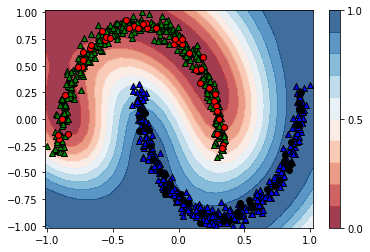

In [21]:
Z = np.reshape(predictions_grid, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])
plt.scatter(x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], c='g', marker='^', edgecolors='k')
plt.scatter(x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], c='b', marker='^', edgecolors='k')
plt.scatter(x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], c='r', marker='o', edgecolors='k')
plt.scatter(x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], c='black', marker='o', edgecolors='k')

plt.ylim(-1.02, 1.02)
plt.xlim(-1.02, 1.02)
plt.savefig('decision_b.png',dpi=700)
plt.show()


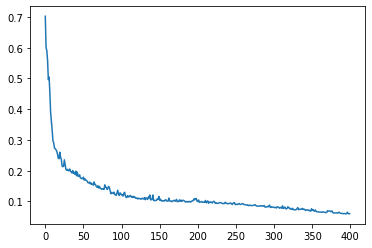

In [18]:
plt.plot(range(400),test_loss)